In [34]:
import numpy as np
import pandas as pd
import statsmodels as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse

In [3]:
ab = pd.read_csv('../data/habsos_20230714.csv', parse_dates=['SAMPLE_DATE'])
ab = ab.sort_values(by=['SAMPLE_DATE'])
ab = ab.dropna(subset=['SALINITY','WATER_TEMP'], how='any')
abfl = ab.loc[ab.STATE_ID=='FL'].copy()

C:\Users\Peter Doze\AppData\Local\Temp\ipykernel_27028\3733098441.py:1: DtypeWarning: Columns (18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  ab = pd.read_csv('../data/habsos_20230714.csv', parse_dates=['SAMPLE_DATE'])


## Prevoius EDA showed that most of the data is from Florida. So we train on Florida and try to predict the others. Previous EDA showed that the data is stationary so we can skip that step

### Recasting the data as Mean Cellcount by Month: a means of trying to standardize the data since the time intervals are irregular. We won't be able to forecast a particular month of algae blooms because the data has no seasonality but we might be able to forecast a month average.

In [4]:
abflgroup = abfl.groupby([abfl.SAMPLE_DATE.dt.year, abfl.SAMPLE_DATE.dt.month])\
    [['CELLCOUNT','SALINITY','WATER_TEMP','SAMPLE_DEPTH']].mean()


In [5]:
idx = [datetime(i[0],i[1],1) for i in abflgroup.index]

In [6]:
ab2 = abflgroup.copy()
ab2.index = idx

### Recasting the datat as Rolling Average by 30 days: a means of preparing the raw data by smoothing it and removing (some) noise, and better expose the structure of the processes.

In [7]:
delta = timedelta(days=30)


In [8]:
ab3 = abfl.copy()
ab3.set_index('SAMPLE_DATE', inplace=True)
cellavg = ab3.CELLCOUNT.rolling(delta, min_periods=1).mean()

### Splitting the data into test and train. I want to forecast on the last three years.

In [12]:
trainab2 = ab2.loc[ab2.index < datetime(2020,1,1)].copy()
testab2 = ab2.loc[ab2.index >= datetime(2020,1,1)].copy()
trainab3 = ab3.loc[ab3.index < datetime(2020,1,1)].copy()
testab3 = ab3.loc[ab3.index >= datetime(2020,1,1)].copy()

## Even though we want to utilize the water temp and salinity, the simple exponential smoothing (for time series with no trend and no seasonality) and ARIMA are built for univariate data, so we will use the water temp and salinity in the random forest model

### Simple Exponential Smoothing

#### ab2 : Average Per Month

In [191]:
alpha = np.arange(0,1.05,0.05)
splitstrain = 12
splitstest = 3

In [114]:
#rmses = np.zeros((len(alpha), splitstrain))

In [115]:
#cv = TimeSeriesSplit(splitstrain, test_size=splitstest)
#cv.split(trainab2)
#for train_index, test_index in cv.split(trainab2):
#    a = test_index
#    print(train_index,test_index)

In [116]:
#a
#trainab2.iloc[a]

In [117]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [118]:
#For some reason doesn't like being in a function, I'm goign to ignore for now
'''def ses(alpha, splitstrain, splitstest, catalog):  
    rmses = np.zeros((len(alpha), splitstrain))
    cv = TimeSeriesSplit(splitstrain, test_size=splitstest)
    c = 0
    for train_index, test_index in cv.split(catalog):
        tv_tt = catalog.iloc[train_index]
        tv_ho = catalog.iloc[test_index]
        print(tv_tt.head())
        for i, j in enumerate(alpha):
            fit = SimpleExpSmoothing(tv_tt.CELLCOUNT.values).fit(smoothing_level=j, optimized=False)
            prediction = fit.forecast(len(tv_ho))
            rmses[i,c] = mse(tv_ho.CELLCOUNT.values, prediction)

            plt.figure(figsize=(10,8))
            plt.plot(tv_ho.index, tv_ho.CELLCOUNT, 'b',label="Test Data")
            plt.plot(tv_ho.index, prediction, 'r',label="Forecast")
            plt.xlabel("Date")
            plt.ylabel("Cell Count")
            plt.title(f"Alpha {j} Simple Exp Smoothing Forecast of Per Month Data")
            plt.legend()
            plt.savefig(f"ab2_simpleExpSmoothing/Alpha_{j}_Simple_Exp_Smoothing_Forecast_of_Per_Month_Data.png")
            plt.close()


        c += 1
        return rmses'''

'def ses(alpha, splitstrain, splitstest, catalog):  \n    rmses = np.zeros((len(alpha), splitstrain))\n    cv = TimeSeriesSplit(splitstrain, test_size=splitstest)\n    c = 0\n    for train_index, test_index in cv.split(catalog):\n        tv_tt = catalog.iloc[train_index]\n        tv_ho = catalog.iloc[test_index]\n        print(tv_tt.head())\n        for i, j in enumerate(alpha):\n            fit = SimpleExpSmoothing(tv_tt.CELLCOUNT.values).fit(smoothing_level=j, optimized=False)\n            prediction = fit.forecast(len(tv_ho))\n            rmses[i,c] = mse(tv_ho.CELLCOUNT.values, prediction)\n\n            plt.figure(figsize=(10,8))\n            plt.plot(tv_ho.index, tv_ho.CELLCOUNT, \'b\',label="Test Data")\n            plt.plot(tv_ho.index, prediction, \'r\',label="Forecast")\n            plt.xlabel("Date")\n            plt.ylabel("Cell Count")\n            plt.title(f"Alpha {j} Simple Exp Smoothing Forecast of Per Month Data")\n            plt.legend()\n            plt.savefig(f"a

In [192]:
rmses = np.zeros((len(alpha), splitstrain))
cv = TimeSeriesSplit(splitstrain, test_size=splitstest)
c = 0
scale=1
for train_index, test_index in cv.split(trainab2):
    tv_tt = trainab2.iloc[train_index]
    tv_ho = trainab2.iloc[test_index]
    print(test_index) #making sure the splits are working
    for i, j in enumerate(alpha):
        fit = SimpleExpSmoothing(tv_tt.CELLCOUNT.values/scale).fit(smoothing_level=j, optimized=False)
        prediction = fit.forecast(len(tv_ho))
        rmses[i,c] = mse(tv_ho.CELLCOUNT.values/scale, prediction, squared=False)

        plt.figure(figsize=(10,8))
        plt.plot(tv_ho.index, tv_ho.CELLCOUNT/scale, 'b',label="Test Data")
        plt.plot(tv_ho.index, prediction, 'r',label="Forecast")
        plt.xlabel("Date")
        plt.ylabel("Cell Count")
        plt.title(f"Alpha {j} Simple Exp Smoothing Forecast of Per Month Data")
        plt.legend()
        plt.savefig(f"ab2_simpleExpSmoothing/Alpha_{j}_Column_{c}_Simple_Exp_Smoothing_Forecast_of_Per_Month_Data.png")
        plt.close()

    
    c += 1


[576 577 578]
[579 580 581]
[582 583 584]
[585 586 587]
[588 589 590]
[591 592 593]
[594 595 596]
[597 598 599]
[600 601 602]
[603 604 605]
[606 607 608]
[609 610 611]


In [94]:
#alpha = np.arange(0,1.05,0.05)
#splitstrain = 12
#splitstest = 3

In [95]:
#rmsessesab2 = ses(alpha, splitstrain, splitstest, trainab2)

[576 577 578]
0


In [193]:
sesrms = np.zeros(len(alpha))
for i,j in enumerate(alpha):
    avg_rms = rmses[i,:].mean()
    sesrms[i] = avg_rms
    k = "{:e}".format(avg_rms)
    print(f"Room Mean Square for Alpha {j} is {k}")

best = "{:e}".format(sesrms.min())
print(f"Best RMS is {best}")

Room Mean Square for Alpha 0.0 is 9.299955e+04
Room Mean Square for Alpha 0.05 is 1.064801e+05
Room Mean Square for Alpha 0.1 is 1.119857e+05
Room Mean Square for Alpha 0.15000000000000002 is 1.145844e+05
Room Mean Square for Alpha 0.2 is 1.155617e+05
Room Mean Square for Alpha 0.25 is 1.155762e+05
Room Mean Square for Alpha 0.30000000000000004 is 1.149759e+05
Room Mean Square for Alpha 0.35000000000000003 is 1.140200e+05
Room Mean Square for Alpha 0.4 is 1.128756e+05
Room Mean Square for Alpha 0.45 is 1.116276e+05
Room Mean Square for Alpha 0.5 is 1.103123e+05
Room Mean Square for Alpha 0.55 is 1.089391e+05
Room Mean Square for Alpha 0.6000000000000001 is 1.075038e+05
Room Mean Square for Alpha 0.65 is 1.059958e+05
Room Mean Square for Alpha 0.7000000000000001 is 1.044034e+05
Room Mean Square for Alpha 0.75 is 1.027155e+05
Room Mean Square for Alpha 0.8 is 1.009203e+05
Room Mean Square for Alpha 0.8500000000000001 is 9.901309e+04
Room Mean Square for Alpha 0.9 is 9.699463e+04
Room Mea

## <span style=color:red> Best Result was Alpha = 1.0 at RMS 9.273882e+04 </span>

#### ab3 : Rolling Average

In [188]:
alpha = np.arange(0,1.05,0.05)
splitstrain = 12
splitstest = 5055 #3/15 of the whole same as for ab2

In [189]:
rmses = np.zeros((len(alpha), splitstrain))
cv = TimeSeriesSplit(splitstrain, test_size=splitstest)
c = 0
scale = 1
for train_index, test_index in cv.split(trainab3):
    tv_tt = trainab3.iloc[train_index]
    tv_ho = trainab3.iloc[test_index]
    print(test_index) #making sure the splits are working
    for i, j in enumerate(alpha):
        fit = SimpleExpSmoothing(tv_tt.CELLCOUNT.values/scale).fit(smoothing_level=j, optimized=False)
        prediction = fit.forecast(len(tv_ho))
        rmses[i,c] = mse(tv_ho.CELLCOUNT.values/scale, prediction, squared=False)

        plt.figure(figsize=(10,8))
        plt.plot(tv_ho.index, tv_ho.CELLCOUNT/scale, 'b',label="Test Data")
        plt.plot(tv_ho.index, prediction, 'r',label="Forecast")
        plt.xlabel("Date")
        plt.ylabel("Cell Count")
        plt.title(f"Alpha {j} Column {c} Simple Exp Smoothing Forecast of Per Month Data")
        plt.legend()
        plt.savefig(f"ab3_simpleExpSmoothing/Alpha_{j}_Column_{c}_Simple_Exp_Smoothing_Forecast_of_Per_Month_Data.png")
        plt.close()

    
    c += 1

[15165 15166 15167 ... 20217 20218 20219]
[20220 20221 20222 ... 25272 25273 25274]
[25275 25276 25277 ... 30327 30328 30329]
[30330 30331 30332 ... 35382 35383 35384]
[35385 35386 35387 ... 40437 40438 40439]
[40440 40441 40442 ... 45492 45493 45494]
[45495 45496 45497 ... 50547 50548 50549]
[50550 50551 50552 ... 55602 55603 55604]
[55605 55606 55607 ... 60657 60658 60659]
[60660 60661 60662 ... 65712 65713 65714]
[65715 65716 65717 ... 70767 70768 70769]
[70770 70771 70772 ... 75822 75823 75824]


In [190]:
sesrms = np.zeros(len(alpha))
for i,j in enumerate(alpha):
    avg_rms = rmses[i,:].mean()
    sesrms[i] = avg_rms
    k = "{:e}".format(avg_rms)
    print(f"Room Mean Square for Alpha {j} is {k}")

best = "{:e}".format(sesrms.min())
print(f"Best RMS is {best}")

Room Mean Square for Alpha 0.0 is 9.338493e+05
Room Mean Square for Alpha 0.05 is 9.332373e+05
Room Mean Square for Alpha 0.1 is 9.334089e+05
Room Mean Square for Alpha 0.15000000000000002 is 9.335069e+05
Room Mean Square for Alpha 0.2 is 9.335560e+05
Room Mean Square for Alpha 0.25 is 9.335757e+05
Room Mean Square for Alpha 0.30000000000000004 is 9.335805e+05
Room Mean Square for Alpha 0.35000000000000003 is 9.335785e+05
Room Mean Square for Alpha 0.4 is 9.335739e+05
Room Mean Square for Alpha 0.45 is 9.335687e+05
Room Mean Square for Alpha 0.5 is 9.335638e+05
Room Mean Square for Alpha 0.55 is 9.335597e+05
Room Mean Square for Alpha 0.6000000000000001 is 9.335568e+05
Room Mean Square for Alpha 0.65 is 9.335552e+05
Room Mean Square for Alpha 0.7000000000000001 is 9.335549e+05
Room Mean Square for Alpha 0.75 is 9.335561e+05
Room Mean Square for Alpha 0.8 is 9.335586e+05
Room Mean Square for Alpha 0.8500000000000001 is 9.335624e+05
Room Mean Square for Alpha 0.9 is 9.335671e+05
Room Mea

## <span style=color:red> Best Result was Alpha = 0.05 at RMS 9.332373e+05 </span>

### ARIMA

#### ab2 : Average Per Month

In [137]:
np.zeros((10,4,4))

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0.,

In [138]:
from sklearn.ensemble import RandomForestRegressor

In [139]:
model = RandomForestRegressor()

In [152]:
trainab2.columns
treeab2 = trainab2.copy()
treeab2test = testab2.copy()

In [158]:
treeab2.reset_index(inplace=True)
treeab2test.reset_index(inplace=True)

In [165]:
treeab2['day'] = treeab2['index'].dt.day.astype(int)
treeab2['month'] = treeab2['index'].dt.month.astype(int)
treeab2['year'] = treeab2['index'].dt.year.astype(int)

In [167]:
treeab2test['day'] = treeab2test['index'].dt.day.astype(int)
treeab2test['month'] = treeab2test['index'].dt.month.astype(int)
treeab2test['year'] = treeab2test['index'].dt.year.astype(int)

In [183]:
scale = 1
target = treeab2['CELLCOUNT']/scale
features = treeab2[['SALINITY', 'WATER_TEMP', 'SAMPLE_DEPTH','day','month','year']]

In [184]:
model.fit(features, target)

RandomForestRegressor()

In [185]:
predictiontree = model.predict(treeab2test[['SALINITY', 'WATER_TEMP', 'SAMPLE_DEPTH','day','month','year']])

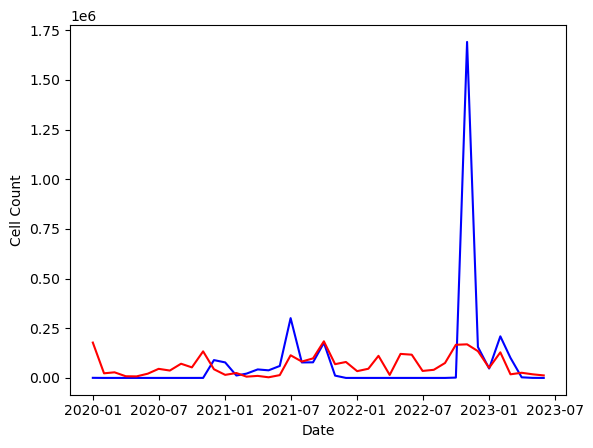

In [186]:
plt.plot(testab2.index,testab2.CELLCOUNT/scale,'b',label='Test Data')
plt.plot(testab2.index, predictiontree,'r',label='Forecast')
plt.xlabel('Date')
plt.ylabel('Cell Count')
plt.show()
plt.close()

In [187]:
print('Root Mean Square is ', "{:e}".format(mse(testab2.CELLCOUNT, predictiontree, squared=False)))

Root Mean Square is  2.454837e+05


In [195]:
treeab3 = trainab3.copy()
treeab3test = testab3.copy()

In [196]:
treeab3.reset_index(inplace=True)
treeab3test.reset_index(inplace=True)

treeab3.head()

,SAMPLE_DATE,STATE_ID,DESCRIPTION,LATITUDE,LONGITUDE,SAMPLE_DEPTH,GENUS,SPECIES,CATEGORY,CELLCOUNT,...,SALINITY_QA,WATER_TEMP,WATER_TEMP_UNIT,WATER_TEMP_QA,WIND_DIR,WIND_DIR_UNIT,WIND_DIR_QA,WIND_SPEED,WIND_SPEED_UNIT,WIND_SPEED_QA
0,1954-02-05 08:55:00,FL,Station A 45; USFWS 1954-57,27.2167,-82.5417,0.5,Karenia,brevis,not observed,0,...,1,18.0,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0
1,1954-02-05 09:35:00,FL,Station A 50; USFWS 1954-57,27.1500,-82.5083,0.5,Karenia,brevis,not observed,0,...,1,18.2,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0
2,1954-02-05 11:35:00,FL,Station A 38; USFWS 1954-57,27.3533,-82.6450,0.5,Karenia,brevis,not observed,0,...,1,18.5,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0
3,1954-02-05 11:52:00,FL,Station A 37; USFWS 1954-57,27.3417,-82.7167,0.5,Karenia,brevis,not observed,0,...,1,18.5,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0
4,1954-02-05 12:10:00,FL,Station A 41; USFWS 1954-57,27.3083,-82.5967,0.5,Karenia,brevis,not observed,0,...,1,18.6,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0


In [198]:
treeab3['day'] = treeab3['SAMPLE_DATE'].dt.day.astype(int)
treeab3['month'] = treeab3['SAMPLE_DATE'].dt.month.astype(int)
treeab3['year'] = treeab3['SAMPLE_DATE'].dt.year.astype(int)

In [199]:
treeab3test['day'] = treeab3test['SAMPLE_DATE'].dt.day.astype(int)
treeab3test['month'] = treeab3test['SAMPLE_DATE'].dt.month.astype(int)
treeab3test['year'] = treeab3test['SAMPLE_DATE'].dt.year.astype(int)

In [211]:
scale = 1
target = treeab3['CELLCOUNT']/scale
features = treeab3[['SALINITY', 'WATER_TEMP', 'SAMPLE_DEPTH','day','month','year']]

In [214]:
#THERES NA IN DATTIME DATA HAVE TO DEAL WITH
inds = pd.isnull(features).any(1)[0]

C:\Users\Peter Doze\AppData\Local\Temp\ipykernel_27028\1831496973.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  inds = pd.isnull(features).any(1)[0]


In [215]:
inds

False

In [219]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75825 entries, 0 to 75824
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SALINITY      75825 non-null  float64
 1   WATER_TEMP    75825 non-null  float64
 2   SAMPLE_DEPTH  75803 non-null  float64
 3   month         75825 non-null  int32  
 4   year          75825 non-null  int32  
dtypes: float64(3), int32(2)
memory usage: 2.3 MB


In [212]:
model.fit(features.dropna(), target.dropna())

ValueError: Found input variables with inconsistent numbers of samples: [75803, 75825]

In [ ]:
predictiontree = model.predict(treeab2test[['SALINITY', 'WATER_TEMP', 'SAMPLE_DEPTH','day','month','year']])

In [ ]:
plt.plot(testab2.index,testab2.CELLCOUNT/scale,'b',label='Test Data')
plt.plot(testab2.index, predictiontree,'r',label='Forecast')
plt.xlabel('Date')
plt.ylabel('Cell Count')
plt.show()
plt.close()

In [ ]:
print('Root Mean Square is ', "{:e}".format(mse(testab2.CELLCOUNT, predictiontree, squared=False)))

In [197]:
trainab3

,STATE_ID,DESCRIPTION,LATITUDE,LONGITUDE,SAMPLE_DEPTH,GENUS,SPECIES,CATEGORY,CELLCOUNT,CELLCOUNT_UNIT,...,SALINITY_QA,WATER_TEMP,WATER_TEMP_UNIT,WATER_TEMP_QA,WIND_DIR,WIND_DIR_UNIT,WIND_DIR_QA,WIND_SPEED,WIND_SPEED_UNIT,WIND_SPEED_QA
SAMPLE_DATE,,,,,,,,,,,,,,,,,,,,,
1954-02-05 08:55:00,FL,Station A 45; USFWS 1954-57,27.21670,-82.54170,0.5,Karenia,brevis,not observed,0,cells/L,...,1,18.00,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0
1954-02-05 09:35:00,FL,Station A 50; USFWS 1954-57,27.15000,-82.50830,0.5,Karenia,brevis,not observed,0,cells/L,...,1,18.20,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0
1954-02-05 11:35:00,FL,Station A 38; USFWS 1954-57,27.35330,-82.64500,0.5,Karenia,brevis,not observed,0,cells/L,...,1,18.50,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0
1954-02-05 11:52:00,FL,Station A 37; USFWS 1954-57,27.34170,-82.71670,0.5,Karenia,brevis,not observed,0,cells/L,...,1,18.50,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0
1954-02-05 12:10:00,FL,Station A 41; USFWS 1954-57,27.30830,-82.59670,0.5,Karenia,brevis,not observed,0,cells/L,...,1,18.60,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 19:25:00,FL,La Contessa Pier,27.81210,-82.81915,0.5,Karenia,brevis,not observed,0,cells/L,...,1,21.14,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0
2019-12-30 20:27:00,FL,Mullet Key; Gulf Pier,27.61330,-82.73910,0.5,Karenia,brevis,not observed,0,cells/L,...,1,21.20,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0
2019-12-30 20:56:00,FL,Wallace Cove (Boca Ciega Bay),27.71170,-82.69014,0.5,Karenia,brevis,not observed,0,cells/L,...,1,21.86,deg. C,1.0,NaN,NaN,9.0,NaN,NaN,9.0


In [206]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75825 entries, 0 to 75824
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SALINITY      75825 non-null  float64
 1   WATER_TEMP    75825 non-null  float64
 2   SAMPLE_DEPTH  75803 non-null  float64
 3   day           75825 non-null  int32  
 4   month         75825 non-null  int32  
 5   year          75825 non-null  int32  
dtypes: float64(3), int32(3)
memory usage: 2.6 MB
